In [1]:
import numpy as np
import matplotlib.pyplot as plt  # required for plotting

from braket.ahs.atom_arrangement import AtomArrangement

a = 5.7e-6  # nearest-neighbor separation (in meters)

register = AtomArrangement()
register.add(np.array([0.5, 0.5 + 1/np.sqrt(2)]) * a)
register.add(np.array([0.5 + 1/np.sqrt(2), 0.5]) * a)
register.add(np.array([0.5 + 1/np.sqrt(2), - 0.5]) * a)
register.add(np.array([0.5, - 0.5 - 1/np.sqrt(2)]) * a)
register.add(np.array([-0.5, - 0.5 - 1/np.sqrt(2)]) * a)
register.add(np.array([-0.5 - 1/np.sqrt(2), - 0.5]) * a)
register.add(np.array([-0.5 - 1/np.sqrt(2), 0.5]) * a)
register.add(np.array([-0.5, 0.5 + 1/np.sqrt(2)]) * a)

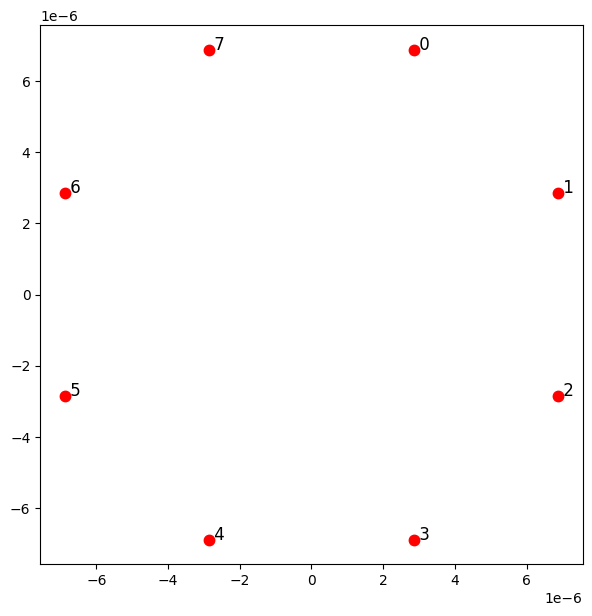

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
xs, ys = [register.coordinate_list(dim) for dim in (0, 1)]
ax.plot(xs, ys, 'r.', ms=15)
for idx, (x, y) in enumerate(zip(xs, ys)):
    ax.text(x, y, f" {idx}", fontsize=12)
plt.show()  # this will show the plot below in an ipython or jupyter session

In [3]:
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

# smooth transition from "down" to "up" state
time_max = 4e-6  # seconds
time_ramp = 1e-7  # seconds
omega_max = 6300000.0  # rad / sec
delta_start = -5 * omega_max
delta_end = 5 * omega_max

omega = TimeSeries()
omega.put(0.0, 0.0)
omega.put(time_ramp, omega_max)
omega.put(time_max - time_ramp, omega_max)
omega.put(time_max, 0.0)

delta = TimeSeries()
delta.put(0.0, delta_start)
delta.put(time_ramp, delta_start)
delta.put(time_max - time_ramp, delta_end)
delta.put(time_max, delta_end)

phi = TimeSeries().put(0.0, 0.0).put(time_max, 0.0)

drive = DrivingField(
    amplitude=omega,
    phase=phi,
    detuning=delta
)

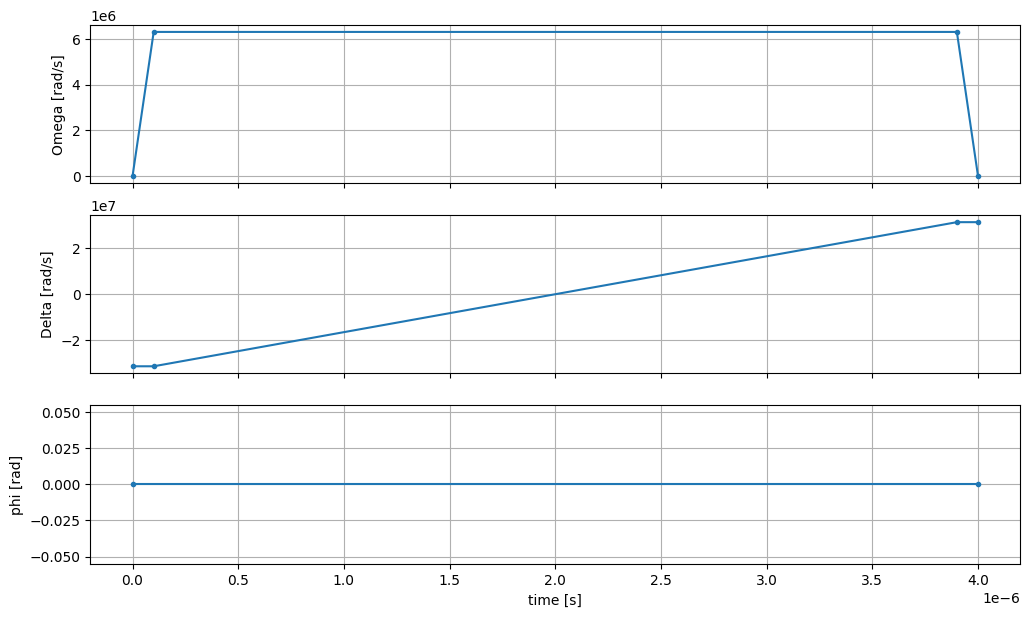

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

ax = axes[0]
time_series = drive.amplitude.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Omega [rad/s]')

ax = axes[1]
time_series = drive.detuning.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Delta [rad/s]')

ax = axes[2]
time_series = drive.phase.time_series
# Note: time series of phase is understood as a piecewise constant function
ax.step(time_series.times(), time_series.values(), '.-', where='post');
ax.set_ylabel('phi [rad]')
ax.grid()
ax.set_xlabel('time [s]')

plt.show()  # this will show the plot below in an ipython or jupyter session


In [5]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register,
    hamiltonian=drive
)

In [6]:
from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

result_simulator = device.run(
    ahs_program,
    shots=1_000_000
).result()  # takes about 5 seconds

In [7]:
from collections import Counter

def get_counts(result):
    """Aggregate state counts from AHS shot results

    A count of strings (of length = # of spins) are returned, where
    each character denotes the state of a spin (site):
       e: empty site
       u: up state spin
       d: down state spin

    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns
        dict: number of times each state configuration is measured

    """
    state_counts = Counter()
    states = ['e', 'u', 'd']
    for shot in result.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state = "".join(map(lambda s_idx: states[s_idx], state_idx))
        state_counts.update((state,))
    return dict(state_counts)

counts_simulator = get_counts(result_simulator)  # takes about 5 seconds
print(counts_simulator)

{'dddddddd': 4, 'dddddddu': 23, 'ddddddud': 27, 'dddddudd': 21, 'dddddudu': 349, 'dddduddd': 22, 'dddduddu': 1567, 'ddddudud': 329, 'dddduduu': 1, 'dddduudu': 2, 'dddudddd': 25, 'dddudddu': 806, 'ddduddud': 1566, 'dddududd': 303, 'dddududu': 4553, 'ddduudud': 1, 'dduddddd': 18, 'dduddddu': 1548, 'ddudddud': 753, 'dduddudd': 1577, 'dduddudu': 39092, 'ddududdd': 296, 'ddududdu': 38994, 'ddududud': 4469, 'ddududuu': 23, 'dduduudu': 49, 'dduuddud': 1, 'dduududd': 1, 'dduududu': 27, 'dudddddd': 29, 'dudddddu': 319, 'duddddud': 1621, 'dudddduu': 1, 'dudddudd': 849, 'dudddudu': 4504, 'dudduddd': 1550, 'dudduddu': 39118, 'duddudud': 39120, 'dudduduu': 39, 'dudduudd': 1, 'dudduudu': 26, 'dududddd': 304, 'dududddu': 4507, 'dududdud': 39094, 'dududduu': 24, 'dudududd': 4528, 'dudududu': 315698, 'dududuud': 21, 'duduuddu': 18, 'duduudud': 25, 'duduuudu': 2, 'duuddddu': 1, 'duuddudd': 1, 'duuddudu': 14, 'duududdu': 36, 'duududud': 19, 'uddddddd': 23, 'udddddud': 299, 'uddddudd': 1516, 'uddduddd': 8

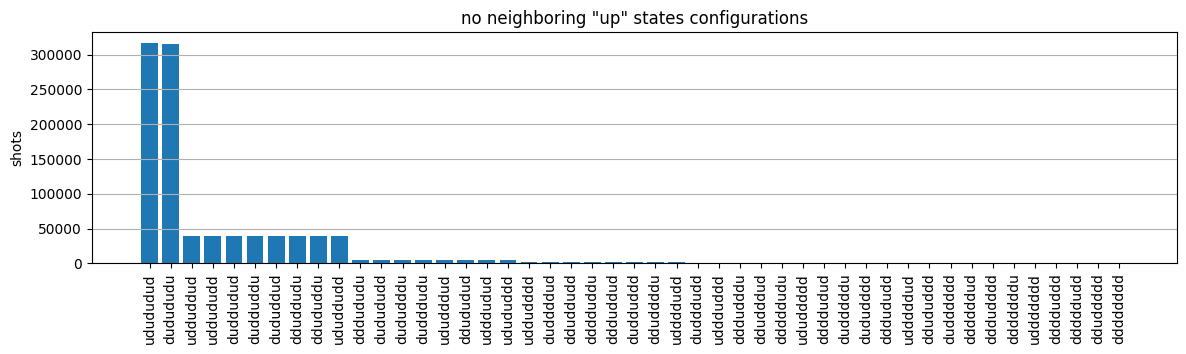

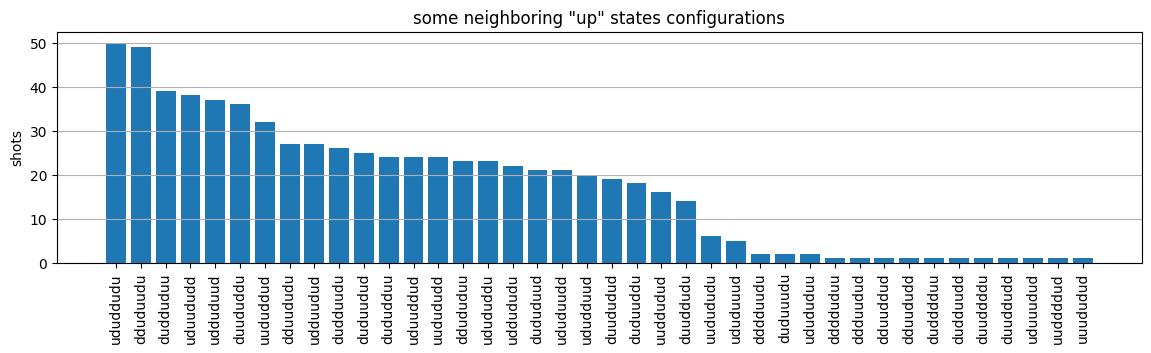

In [9]:
from collections import Counter

def has_neighboring_up_states(state):
    if 'uu' in state:
        return True
    if state[0] == 'u' and state[-1] == 'u':
        return True
    return False

def number_of_up_states(state):
    return Counter(state)['u']

def plot_counts(counts):
    non_blockaded = []
    blockaded = []
    for state, count in counts.items():
        if not has_neighboring_up_states(state):
            collection = non_blockaded
        else:
            collection = blockaded
        collection.append((state, count, number_of_up_states(state)))

    blockaded.sort(key=lambda _: _[1], reverse=True)
    non_blockaded.sort(key=lambda _: _[1], reverse=True)

    for configurations, name in zip((non_blockaded,
                                    blockaded),
                                    ('no neighboring "up" states',
                                    'some neighboring "up" states')):
        plt.figure(figsize=(14, 3))
        plt.bar(range(len(configurations)), [item[1] for item in configurations])
        plt.xticks(range(len(configurations)))
        plt.gca().set_xticklabels([item[0] for item in configurations], rotation=90)
        plt.ylabel('shots')
        plt.grid(axis='y')
        plt.title(f'{name} configurations')
        plt.show()

plot_counts(counts_simulator)